In [1]:
#!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
#!pip install torch_geometric
#!pip install pyvista
#%pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-2.0.1+cpu.html
#%pip install pyvista==0.44.1

In [2]:
import torch
from torch_geometric.data import Data
import pyvista as pv
from utils import *
torch.__version__, pv.__version__

/home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/libpyg.so: undefined symbol: _ZN3c109TupleTypeC1ESt6vectorINS_4Type24SingletonOrSharedTypePtrIS2_EESaIS4_EESt8optionalINS_13QualifiedNameEESt10shared_ptrINS_14FunctionSchemaEE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/libpyg.so: undefined symbol: _ZN3c109TupleTypeC1ESt6vectorINS_4Type24SingletonOrSharedTypePtrIS2_EESaIS4_EESt8optionalINS_13QualifiedNameEESt10shared_ptrINS_14FunctionSchemaEE
  warnings.warn(f"An issue occurred while importing 'torch-spar

('2.0.1+cu117', '0.44.1')

In [3]:
data = torch.load('./sampleData.pth')
data.edge_index = np.empty((2, 0))
transform = DelaunayTransform()
data = transform(data)
def plot_graph(data, l=1, plotter=None, node_colors=None):
    
    c = ['r', 'g', 'b', 'm']
    
    p = pv.Plotter() if plotter is None else plotter
    
    # Création d'un PolyData pour les points (nœuds)
    mesh = pv.PolyData()
    
    # Gestion des dimensions des positions
    if data.pos.shape[1] != 3:
        # Ajouter une troisième dimension si nécessaire
        mesh.points = np.concatenate([data.pos.cpu().numpy(), np.full((data.pos.shape[0], 1), l)], axis=1)
    else:
        mesh.points = data.pos.cpu().numpy()

    # Création des lignes pour les arêtes
    edges = data.edge_index.t().cpu().numpy()
    lines = np.hstack([np.full((edges.shape[0], 1), 2), edges]).ravel()
    mesh.lines = lines
    
    
    # Ajout des couleurs au PolyData
    mesh.point_data['values'] = node_colors if node_colors is not None else np.random.randint(0, 255, size=(data.pos.shape[0], 3))
    
    # Ajouter le mesh avec les couleurs des nœuds
    p.add_mesh(mesh, scalars='values', line_width=0.5, point_size=0.3, render_points_as_spheres=True)

    # Si aucun plotter n'a été fourni, on montre la figure
    if plotter is None:
        p.show()
        
data.edge_index.shape

torch.Size([2, 1019114])

In [4]:
%%timeit
divide_mesh(data.pos, data.edge_index.T, 6)

580 ms ± 35.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


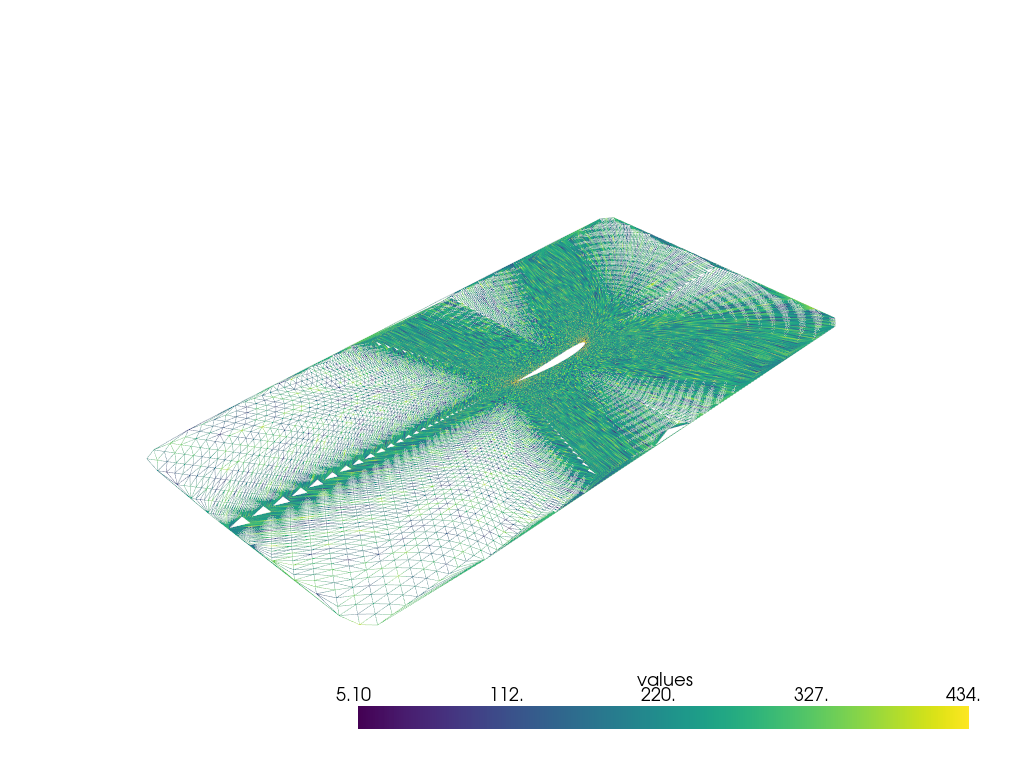

In [5]:
import matplotlib.pyplot as plt

plot_graph(data)


In [10]:
device = torch.device('cuda')
b = generate_coarse_graphs(data, R=3, K=6)
b

Data(x=[190702, 5], edge_index=[2, 1329524], y=[170180, 4], pos=[190702, 2], surf=[190702], clusters=[18], node_clusters=[18], R=3, clusters_per_layer=6, edge_frequencies=[3], layer_ranges=[3, 2], up_scale_edge_ranges=[2, 2])

In [7]:
%%timeit
device = torch.device('cuda')
b = generate_coarse_graphs(data, R=3, K=6)
#plot_graph(b)

849 ms ± 25.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
b = b.to(device)
b.layer_ranges

tensor([[     0, 170180],
        [170179, 187646],
        [187645, 190702]], device='cuda:0', dtype=torch.int32)

In [9]:
#%%timeit
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
import importlib
import my_model
importlib.reload(my_model)

# Reload the model
model = my_model.UaMgnn(5, 4, R=3, K=5, device=device)
print("N nodes: ", b.pos.shape[0], "N edges: ", b.edge_index.shape[1])
model(b).shape

N nodes:  190702 N edges:  1329524


../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [669,0,0], thread: [32,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [669,0,0], thread: [33,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [669,0,0], thread: [34,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [669,0,0], thread: [35,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [669,0,0], thread: [36,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [669,0,0], thread: [37,0,0] Assertion 

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [61]:
#color = torch.tensor([0.0], device=device)
#colors = color.repeat(b.pos.shape[0], 1)
#colors[torch.logical_not(b.surf)] = torch.tensor([1.0], device=device)
#print(torch.mean(colors, dim=0), flush=True)
#plot_graph(b, l=1, node_colors=colors.cpu().numpy())


In [4]:
edge_index = torch.IntTensor([
    [0, 1, 2, 3],
    [1, 2, 3, 4]
])   

node_index = torch.IntTensor([0, 1, 2, 3, 4])
nodes_index_of_subgraph = torch.IntTensor([0, 1, 3, 4])
edge_indices_of_subgraph = torch.IntTensor([0, 3])

mask = torch.full((node_index.shape[0],), 1, dtype=torch.int32)
mask[nodes_index_of_subgraph] = 0

mask = torch.cumsum(mask, dim=0)
edge_of_subgraph = edge_index[:, edge_indices_of_subgraph]
edge_of_subgraph -= mask[edge_of_subgraph]

edge_of_subgraph

tensor([[0, 2],
        [1, 3]], dtype=torch.int32)